<h1><a id='outline'>Project Outline</a></h1>

* [Data Pre-Processing](#dpp)
  *  [Required Libraries](#libs)
  *  [Separate Data](#sep)
  *  [General Data Overview](#gdo)
* [Question 1](#rq1d)
  *  [Read in Q1 Data](#rq1d)
  *  [Quality Score Distribution](#sep)
  *  [Separate Data](#sep)
  *  [Question 1a](#q1a)
  *  [Question 1b Code](#q1bc)
  *  [Question 1b Answer](#q1ba)
  *  [Question 1c Code](#q1cc)
  *  [Question 1c Answer](#q1ca)
  *  [Question 1d](#q1d)
  *  [Question 1e](#q1e)
* [Question 2](#q2cc)
  * [Question 2 Code](#q2cc)
  * [Question 2 Answer](#q2ab)
  * [Question 2c](#q2c)

<h2><a id="dpp">Data prep and cursory analysis</a></h2>

<h4><a id="libs">Python Libraries and Jupyter Magic</a></h4>

In [1]:
%matplotlib inline
%load_ext rpy2.ipython
from pandas import Series
from collections import Counter
from rpy2.robjects.packages import STAP
from rpy2.robjects.vectors import FloatVector as rArray
from Locus import *
from os import chdir
import rpy2.rinterface
import pickle
chdir("/mnt/research/germs/shane/Classes/BCB_2_ComputationalStats/HW1")

#### Separate Data
<a id="sep"></a>
##### Divide the data by individual and position because github wont allow large files and this will allow us to only load small amounts of data into memory at a time

In [2]:
%%bash
cd data/
for individual in {0..2}; do 
    for pos in {764..1199}; do
        awk -v individual="$individual" -v pos="$pos" '($1==individual && $3==pos && $4!="NA") {print $0}' genotyping.txt > Individual$individual\_position$pos.txt
    done

#### General Data Overview 
<a id="gdo"></a>
<ol style="display: inline; padding: 0;margin-top: -10px;"> <p style="display: inline; padding: 0;margin-top: -10px;"><u>Genotyping.txt Column Designations:</u></p>
    <li>Id of individual</li>
    <li>Id of read</li>
    <li>Reference position</li>
    <li>Read base call</li>
    <li>Read quality score</li>
</ol>

In [4]:
%%bash 
head data/Individual0_position962.txt

0 0 962 A p
0 1 962 A h
0 2 962 A i
0 3 962 A l
0 4 962 G X
0 5 962 G p
0 6 962 G p
0 7 962 A p
0 8 962 A p
0 9 962 G r


[Project Outline](#outline)
### Question 1
##### Read in Q1 Data
<a id="rq1d"></a>

In [2]:
class SeqRead:
    def __init__(self,data):
        rec = data.strip().split()
        self.q = ord(rec[4]) - 33
        self.errorProb = 10.0**((-self.q)/10.0)
        self.call = rec[3]
        self.matchesRef = False
        
pos962,pos964 = [],[]
for line in open("data/Individual0_position962.txt"): pos962.append(SeqRead(line))
for line in open("data/Individual0_position964.txt"): pos964.append(SeqRead(line))
positions = [pos962,pos964]
data, all_qs, all_errors, all_calls = [],[],[],[]
for pos in positions:
    calls, errorProbs, qscores = [],[],[]
    for read in pos:
        qscores.append(read.q)
        errorProbs.append(read.errorProb)
        calls.append(int(read.call=='A'))
    all_calls.append(calls)   
    all_qs.append(qscores) 
    all_errors.append(errorProbs)
    qscores = Series(qscores)
    data.append(qscores)

##### Describe and plot the distribution of Q scores to see data quality
<a id="q1qc"></a>

Individual 0 Position 962 Quality score Distribution
 count    8883.000000
mean       71.602837
std        13.239879
min         3.000000
25%        71.000000
50%        78.000000
75%        80.000000
max        81.000000
dtype: float64


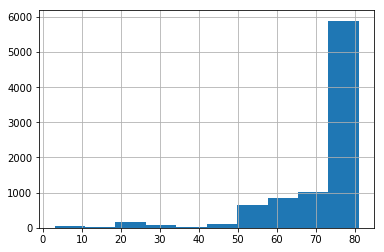

In [3]:
print("Individual 0 Position 962 Quality score Distribution\n",data[0].describe())
data[0].hist().plot();

Individual 0 Position 964 Quality score Distribution
 count    8886.000000
mean      108.660027
std         9.702624
min        36.000000
25%       110.000000
50%       113.000000
75%       113.000000
max       114.000000
dtype: float64


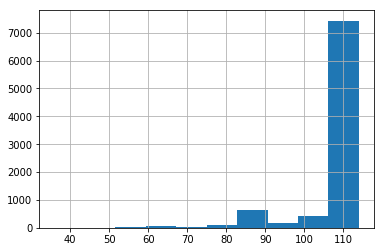

In [17]:
print("Individual 0 Position 964 Quality score Distribution\n",data[1].describe())
data[1].hist().plot();

[Project Outline](#outline)
<h5><a id='q1a'>Question 1a.</a></h5>

![](images/Q1A.png)

$L(g|Z_1,Z_2,...,Z_l)$ def $\stackrel{def}{=}$ $Pr(Z_1=z_1,Z_2=z_2,...,Z_l=z_l|G=g)$ 

$\stackrel{CP}{=}$ $\frac{Pr(Z_1=z_1 \cap Z_2=z_2 \cap...\cap Z_l=z_l\cap G=g)}{Pr(G=g)}$

$\stackrel{MR}{=}$ $\frac{1}{Pr(G=g)} * Pr(Z_1=z_1) * Pr(Z_2=z_2|Z_1=z_1) * Pr(Z_3=z_3|Z_1=z_1 \cap Z_2=z_2) * ... * Pr(Z_l=z_l | Z_1=z_1 \cap ... \cap Z_{l-1}=z_{l-1}) * Pr(G=g|Z_1=z_1 \cap ... \cap Z_l=z_l)$ 

Since G is independent of Z_n,

$Pr(G = g | Z_1=z_1  \cap ... \cap  Z_l=z_l)$ = Pr(G = g)

and Pr(G = g) cancels.

$\stackrel{Independance\: of \:reads}{=}$ $Pr(Z_1=z_1)Pr(Z_2=z_2)...Pr(Z_l=z_l)$

$\stackrel{WLOG}{=}$ ${\displaystyle \prod_{j=1}^{k} Pr(Z_j=1)}$ $\cdot$ ${\displaystyle \prod_{j=k+1}^{l} Pr(Z_j=0)}$

where $Z_j= \mathbb{1}\{D_j=b_r\}$ is an indicator function matching the read $b_r$ to the reference allele $D_j$. A read either matches the reference $Z_j = 1$ or it doesn't $Z_j = 0$

##### From the class lecture notes we know that Li makes the assumption that the probability of an error in observing a particular call in a read at a specific site is equal to $10^{-(ord(q)-33)/10}$ where q is the quality score of the read from the sequencer, which is recorded in the fastq file. So, the probability of an error $10^{-(ord(q)-33)/10}$ = $e_{ijs}$


![](images/Tree.jpeg)

Given that we are dealing with a diploid, we have to adjust the probability of an error for the read by the ploidy.

Using the picture above we substituted the $Pr(Z_j = 0)$ and $Pr(Z_j = 1)$ with their respective tree combinations of the probility of having a success or failure to come up with the final equation mapping the probability of a genotype at a position given the reads at observed at that position.

In [2]:
%%bash
pwd
ls images

/mnt/research/germs/shane/Classes/BCB_2_ComputationalStats/HW1
Q1A.png
Tree.jpeg


[Project Outline](#outline)
<h5>Question 1b.</h5>
&nbsp; Use the data from three diploids at https://dorman.stat.iastate.edu/files/genotyping.txt to compute the likelihood of the data in individual 0 at sites 962 and 964 assuming the reference base in both cases is $n_{b}$ = A. What are your maximum likelihood estimates $\hat{G}_{MLE,962}$ and $\hat{G}_{MLE,964}$ of the genotypes? (These data are unforgivingly huge, so you may want to do selective reading of the data in some smart way.)</p>
<br/>
<h5><a id='q1bc'>Question 1b Code</a></h5>

###### The code below (written by me) is taking the stored R functions in the file Q1_MLE.R (modified from the R code in the class notes) and converting it to python functions which I then call. For your convenience I have displayed the function being used in R magic, though the R magic cell doesn't actually do anything.

In [3]:
with open('Q1_MLE.R', 'r') as fh: rtext = fh.read()
rfuncts = STAP(rtext,"")

In [5]:
%%R
log.likelihood.d.g <- function(genotype, calls, ploidy, errorProbs, coverage){
  -coverage*log(ploidy) +
  sum(
      log(
          ifelse(  calls == 1, 
                   genotype * (1 - errorProbs) + (ploidy - genotype) * errorProbs/3, 
                   (1 - errorProbs) * (ploidy - genotype) + genotype * errorProbs + (2*errorProbs*(ploidy-genotype))/3 
                 )
          )
      )
}

In [4]:
for pos in range(0,2):
    print("Finding MLE:")
    calls = all_calls[pos]
    errorProbs = all_errors[pos]
    maxScore = None
    G = None
    for g in range(0,3):
        L = rfuncts.log_likelihood_d_g(g,rArray(calls),2,rArray(errorProbs),len(calls))[0]
        if not maxScore or maxScore < L: 
            maxScore=L
            G=g
    print (maxScore,G)

Finding MLE:
-6152.268491224305 1
Finding MLE:
-6160.344705015218 1


<h5>Question 1b Answer</h5>
The results above show that $\hat{G}_{MLE,962}$ = 1, given that the max of the likelihood function is -6152.268. $\hat{G}_{MLE,964}$ is also equal to 1 with the max of the likelihood function of -6160.3447.

<h5>Question 1c</h5>
Now find the maximum a posterior estimates $\hat{G}_{MAP,962}$ and $\hat{G}_{MAP,964}$ and explain any additional assumptions you make.
<h5><a id='q1cc'>Question 1c Code</a></h5>

In [9]:
%%R
log.likelihood.MAP <- function(g, a, m, e, k){
  -k*log(m) + log(0.5) +
    sum(
        log(
            ifelse(  a == 1, 
                     g * (1 - e) + (m - g) * e/3, 
                     (1 - e) * (m - g) + g * e + (2*e*(m-g))/3
                  )
        )
    )
}

In [ ]:
def MatchesRefMLE(df,g,m,k):
    
    
    

In [6]:
for pos in range(0,2):
    print("Finding MAP:")
    calls = all_calls[pos]
    errorProbs = all_errors[pos]
    maxScore = None
    G = None
    for g in range(0,3):
        L = rfuncts.log_likelihood_MAP(g,rArray(calls),2,rArray(errorProbs),len(calls))[0]
        if not maxScore or maxScore < L: 
            maxScore=L
            G=g
    print (maxScore,G)

Finding MAP:
-6152.961638404865 1
Finding MAP:
-6161.037852195778 1


<h4><a id='q1ca'>Question 1c Answers</a></h4>
$\hat{G}_{MAP,962}$ and $\hat{G}_{MAP,964}$ are both one. We assumed a prior $P(G = g)$ of .5. We chose this value because our null hypothesis is that the individual these reads came from is homozygous reference. Having no knowledge of the reference allele, we chose .5 because the position is either a SNP or not a SNP, so one of 2 possibilities. We could have chose many other priors, but since $P(G = g)$ only scales the maximum likelihood, any value we put would give us the same result.

<h4><a id='q1d'>Question 1d</a></h4>

##### What is your confidence in the MAP estimates? Provide a numeric measure of that confidence.

Using the code below. we attempted to get a numerical estimate by using Asymptotic Confidence Intervals as described in the SNP calling notes from class. However, when we implemented the functions we (I) must have done something wrong with the derivations because for both we get a pval of 0, which is about what we would expect given that the data shows that there is a SNP there. From further searching I see that we were supposed to use the likelihood of \psi but we ran out of time to make it work. 

In [55]:
from scipy.stats import chi2
Ls = rfuncts.log_likelihood_gmap("data/Pos962_data.txt")
L_Ho = float(Ls[2])
print (L_Ho)
L_Ha = min(float(Ls[0]),float(Ls[1]))
print (L_Ha)
Lambda = L_Ho/L_Ha
print(Lambda)
lambd = -2*log(Lambda)
print("lambda:",lambd)
print(chi2.pdf(lambd,1))
print("\n")

Ls = rfuncts.log_likelihood_gmap("data/Pos964_data.txt")
L_Ho = float(Ls[2])
print (L_Ho)
L_Ha = min(float(Ls[0]),float(Ls[1]))
print (L_Ha)

Lambda = L_Ho/L_Ha
print(Lambda)
lambd = -2*log(Lambda)
print("lambda:",lambd)
print (chi2.pdf(lambd,1))


-83316.69248101514
-67592.65415952701
1.2326293961526864
lambda: -0.4182992163208919
0.0


-89699.69855779826
-69222.3349671043
1.2958201800101827
lambda: -0.5182876766225387
0.0


In [30]:
for fileName in ["data/Pos962_data.txt","data/Pos964_data.txt"]:
    psi = rfuncts.estimate_psi(fileName)[0]

0.49999968218679913
0.49999968218679913


<h4><a id='q1e'>Question 1e</a></h4>

##### You should always look at your data and numeric summaries of it to make sure the data are consistent with assumptions your model is making. Do you see anything unusual in the data from these two sites? Are your conclusions and confidence affected?

No, we already took a look at the data and 1 seems like a good estimate for the parameter G given that there appears to be a roughly equal number of A's and G's. Based on the quality score graphs I showed above we have really high quality reads so our answers wouldn't change.

<h3>Question 2</h3>
&nbsp; <p><b>a.</b>Produce a space-separated text file with the individual in set{0,1,2}, the site in set{764,765,...,1199}, and the p-value for rejecting H0. For computing the p-value, use Monte Carlo sampling to estimate</p>
<h4><a id='q2cc'>Question 2 Code</a></h4>

##### Python Helper classes and functions

In [7]:
from collections import Counter     
class Locus:
    def __init__(self,pos):
        self.majorAllele = None
        self.majorAlleleCount = -1
        self.qscores = {0:[],1:[],2:[]}
        self.errorProbs = {0:[],1:[],2:[]}
        self.reads = {0:[],1:[],2:[]}
        self.callMatchRef = {0:[],1:[],2:[]}
        nuc_counter = {'A':0, 'C':0, 'G':0, 'T':0}
        self.read_counter = {0:nuc_counter.copy(),    1:nuc_counter.copy(),    2:nuc_counter.copy()}
        self.total_reads = {0:0,1:0,2:0}
        
    def __iter__(self):
        for key in self.qscores.keys():yield key
            
    def add(self,line,individual):
        if line != "":
            read = SeqRead(line)
            self.reads[individual].append(read)
            self.errorProbs[individual].append(read.errorProb)
            self.read_counter[individual][read.call] += 1
            self.total_reads[individual] += 1

    def calcMajorAllele(self):
        totals = {}
        for base in ['A','C','G','T']:
            for i in range(0,3):
                try: totals[base] += self.read_counter[i][base]
                except: totals[base] = self.read_counter[i][base]
        totals = Counter(totals)
        self.majorAllele, self.majorAlleleCount = totals.most_common(1)[0] 
        
        for ind in self:
            for read in self.reads[ind]:
                self.callMatchRef[ind].append(int(read.call == self.majorAllele))
#                 self.qscores[ind].append(read.q)
        
def ProcessPosition(pos):
    curLocus = Locus(pos)
    i_0_file = "data/Individual0_position%i.txt" % pos
    i_1_file = "data/Individual1_position%i.txt" % pos
    i_2_file = "data/Individual2_position%i.txt" % pos
    for line in open(i_0_file): curLocus.add(line,0)
    for line in open(i_1_file): curLocus.add(line,1)
    for line in open(i_2_file): curLocus.add(line,2)
    curLocus.calcMajorAllele()
    return curLocus        

  #### R functions and R Coversion helper object

In [4]:
from rpy2.robjects.packages import STAP
from rpy2.robjects.vectors import FloatVector as rArray
with open('Q2_DPBinomial.R', 'r') as fh: rtext = fh.read()
rfuncts = STAP(rtext,"")

In [1]:
import datetime
from scipy.stats import bernoulli
rbern=bernoulli.rvs 
import time
nsims = 1000
output = open("Question2.txt","w")
output.write("Individual Pos MC-PVal PA-Pval NA-PVal BA-PVal MCBN-PVal\n")
output.close()
data=None
failed, totalRuns = 0, 0
for pos in range(764,764):
    print( str(datetime.datetime.now()).split('.')[0])
    print(pos)
    data = ProcessPosition(pos)
    for individual in data:
        print(individual,pos,data.read_counter[individual],)
        if data.total_reads[individual] == 0: #if there are no reads for that individual at that position
            #output.write("%i %i %0.4f %0.4f %0.4f %0.4f %0.4f\n" % (individual,pos,0.0,0.0,0.0,0.0,0.0))
            continue
        successfulTrials = 0
        refAllele = data.majorAllele
        for sim in range(nsims):
            numMatchesRef = 0
            for read in data.reads[individual]:
                #randomDraw = bern random (1-eij,1)
                rdraw = rbern(1 - read.errorProb, size=1)[0]
                numMatchesRef += rdraw
            if numMatchesRef <= data.read_counter[individual][refAllele]: successfulTrials+=1
            else: failed+=1
            totalRuns+=1
        MC_PVal   = successfulTrials/float(nsims)
        PA_Pval   = rfuncts.dpbinom(data.read_counter[individual][refAllele],rArray(data.qscores[individual]),method="PA")[0]
        NA_PVal   = rfuncts.dpbinom(data.read_counter[individual][refAllele],rArray(data.qscores[individual]),method="NA")[0]
        BA_PVal   = rfuncts.dpbinom(data.read_counter[individual][refAllele],rArray(data.qscores[individual]),method="BA")[0]
        MCBN_PVal = rfuncts.dpbinom(data.read_counter[individual][refAllele],rArray(data.qscores[individual]),method="MC")[0]
        #outString = "\t".join([str(individual),str(pos),"%0.8f" % MC_PVal,"%0.8f" % PA_Pval,"%0.8f" % NA_PVal,"%0.8f" % BA_PVal,"%0.8f" % MCBN_PVal,str(data.read_counter[individual],)])
        #output.write(outString+"\n")
        output = open("Question2.txt","a")
        output.write("%i %i %0.4f %0.4f %0.4f %0.4f %0.4f\n" % (individual,pos,MC_PVal,PA_Pval,NA_PVal,BA_PVal,MCBN_PVal))
        output.close()
output.close() 

<h4><a id='q2ab'>Question 2 A and B Answer Sample</a></h4>

In [9]:
%%bash
head Question2_output.txt
tail Question2_output.txt

Individual Pos MC-PVal PA-Pval NA-PVal BA-PVal MCBN-PVal
0 1000 0.0000 0.4502 0.0000 0.0000 0.0000
1 1000 0.0000 0.4338 0.0000 0.0000 0.0000
2 1000 0.0000 0.0000 0.0000 0.0000 0.0000
0 1001 0.0000 0.0004 0.0000 0.0000 0.0000
1 1001 0.0000 0.0001 0.0000 0.0000 0.0000
2 1001 0.0000 0.0000 0.0000 0.0000 0.0000
0 1002 0.0000 0.3759 0.0000 0.0000 0.0000
1 1002 0.0000 0.3815 0.0000 0.0000 0.0000
2 1002 0.0000 0.4128 0.0000 0.0000 0.0000
2 996 0.0000 0.4445 0.0000 0.0000 0.0000
0 997 0.1820 0.4891 0.1371 0.2498 0.0725
1 997 0.0000 0.4615 0.0001 0.0103 0.0001
2 997 0.0000 0.4368 0.0000 0.0000 0.0000
0 998 0.0000 0.4054 0.0000 0.0000 0.0000
1 998 0.0000 0.4070 0.0000 0.0000 0.0000
2 998 0.0000 0.3695 0.0000 0.0000 0.0000
0 999 0.0000 0.4496 0.0000 0.0000 0.0000
1 999 0.0000 0.4745 0.0000 0.0019 0.0000
2 999 0.0000 0.3575 0.0000 0.0000 0.0000


[Project Outline](#outline)
<h4><a id='q2c'>Question 2c</a></h4>
For the most part I believe the results make sense. When we se a lot of reads that are all the same base we get 0 or close to 0. When there is a clear het, we get larger p values. The poison method appear to never have significant pvalues. The closest distribution to our monte carlo sampling mimicing a poisson binomail is the monte carlo simulation using a binomail.

[Project Outline](#outline)
### Question 3

# Question 3

In [4]:
#Identify all the sites whose support for homozygosity is high
with open('Q1_MLE.R', 'r') as fh: rtext = fh.read()
rfuncts = STAP(rtext,"")
Gmaps = set()
remove=set()
for pos in range(764,1200):
#     print (pos, end=" ")
    data = ProcessPosition(pos)
    for ind in [0,1,2]:
        if data.total_reads[ind] == 0 : continue
        maxScore = rfuncts.log_likelihood_MAP(2,rArray(data.callMatchRef[ind]),2,rArray(data.errorProbs[ind]),data.total_reads[ind])[0]
        gIs2 = True
        for g in range(1,0,-1):
            L = rfuncts.log_likelihood_MAP(g,rArray(data.callMatchRef[ind]),2,rArray(data.errorProbs[ind]),data.total_reads[ind])[0]
            if maxScore < L: 
                gIs2 = False
                remove.add(pos)
                break
        if gIs2: Gmaps.add(pos)
print(len(Gmaps.difference(remove)),len(Gmaps))
homozygousPositions = Gmaps.difference(remove)

310 418


In [12]:
#Group by TrueBase

all_reads = {}
all_qs = set()
for pos in homozygousPositions:
    print(pos,end=" ")
    data = ProcessPosition(pos)
    ma = data.majorAllele
    all_reads[ma] = {'A':{},'C':{},'G':{},'T':{}} #{B=b:{readCall:{q:count}}}
    for ind in data:
        for read in data.reads[ind]:
            matchesRef = int(read.call == ma)
            all_qs.add(read.q)
            try: all_reads[ma][read.call][read.q] +=1
            except: 
                try:all_reads[ma][read.call][read.q] = 1
                except:
                    try: all_reads[ma][read.call] = {read.q:1}
                    except: all_reads[ma] = {read.call:{read.q:1}}
            
pickle.dump(all_reads,open("aggregatedByMatchRefData.p","wb"))       

    

765 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 840 841 842 843 844 845 846 847 848 849 850 851 852 853 855 856 857 858 859 860 861 862 863 864 865 867 868 869 870 871 872 873 874 875 876 877 879 880 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899 900 901 903 907 908 915 921 930 932 935 942 952 955 956 957 958 961 965 966 967 970 972 977 980 983 986 991 993 996 997 998 999 1002 1005 1006 1007 1008 1011 1021 1028 1031 1033 1042 1048 1055 1056 1060 1062 1063 1064 1065 1066 1067 1068 1069 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1083 1084 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095 1096 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107 1108 1110 1111 1112 1113 1114 1115 1116 1117 1118 1119 1120 11

In [13]:
all_qs

{2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82}

In [5]:
import pickle
all_reads = pickle.load(open("aggregatedByMatchRefData.p","rb"))
all_reads

{'A': {'A': {70: 9074,
   52: 110,
   63: 259,
   67: 356,
   62: 66,
   66: 82,
   64: 199,
   49: 279,
   69: 1,
   65: 4,
   68: 4},
  'C': {50: 1, 49: 1},
  'G': {67: 2, 66: 3, 49: 2, 65: 1},
  'T': {49: 1}},
 'G': {'A': {62: 1, 51: 3, 65: 3, 66: 5, 49: 2},
  'C': {67: 1},
  'G': {65: 2082,
   66: 3744,
   63: 292,
   67: 2988,
   68: 500,
   64: 320,
   51: 111,
   69: 49,
   49: 237,
   62: 94,
   70: 3},
  'T': {62: 1, 66: 1, 67: 1, 49: 4, 51: 2}},
 'C': {'A': {}, 'C': {65: 1}, 'G': {}, 'T': {}},
 'T': {'A': {67: 2, 65: 2, 66: 1},
  'C': {65: 4, 49: 1, 67: 2, 66: 4, 62: 1},
  'G': {65: 1, 62: 2},
  'T': {66: 3543,
   65: 2929,
   67: 2831,
   62: 194,
   64: 56,
   63: 148,
   51: 117,
   68: 397,
   69: 33,
   49: 139}}}

In [16]:
print(len(all_qs))
totals = {'A':[],'C':[],'T':[],'G':[]}
for q in all_qs:
    for refBase, calls in all_reads.items():
        if q not in all_reads[refBase][refBase]:
            numReadsMatchRefandQ = 0
        else:
            numReadsMatchRefandQ = all_reads[refBase][refBase][q]
        numReadsNotMatchingRefandQ = 0
        for readCall in calls:
            if refBase == readCall: continue
            try:
                numReadsNotMatchingRefandQ += all_reads[refBase][readCall][q]
            except:pass #Do nothing
        if numReadsMatchRefandQ == 0 and numReadsNotMatchingRefandQ==0:continue
        print (q,refBase,numReadsMatchRefandQ,numReadsNotMatchingRefandQ)
            
            
    

81
16 A 279 4
16 G 237 6
16 T 139 1
17 A 0 1
18 G 111 5
18 T 117 0
19 A 110 0
29 A 66 0
29 G 94 2
29 T 194 3
30 A 259 0
30 G 292 0
30 T 148 0
31 A 199 0
31 G 320 0
31 T 56 0
32 A 4 1
32 G 2082 3
32 C 1 0
32 T 2929 7
33 A 82 3
33 G 3744 6
33 T 3543 5
34 A 356 2
34 G 2988 2
34 T 2831 4
35 A 4 0
35 G 500 0
35 T 397 0
36 A 1 0
36 G 49 0
36 T 33 0
37 A 9074 0
37 G 3 0


In [21]:
tester={}
data = ProcessPosition(768)
for read in data.reads[1]:
    try:tester[read.q] += 1
    except:tester[read.q] = 1
print(tester)

{64: 197, 65: 2538, 66: 4219, 67: 3592, 63: 210, 62: 156, 68: 601, 69: 54, 49: 198, 51: 106}


In [20]:
print(data.total_reads)


{0: 8875, 1: 11871, 2: 0}


In [19]:
data = ProcessPosition(964)
data.callMatchRef[ind]
data.errorProbs[ind]
rfuncts.log_likelihood_MAP(1,rArray(data.callMatchRef[ind]),2,rArray(data.errorProbs[ind]),data.total_reads[ind])[0]

-6158.9693702291115

In [ ]:
total
for data in all_reads

In [20]:
rfuncts.log_likelihood_d_g(1,rArray(calls),2,rArray(errorProbs),len(calls))[0]

-6160.344705015218

In [ ]:
Gmaps = []

for pos in range(0,2):
    print("Finding MAP:")
    calls = all_calls[pos]
    errorProbs = all_errors[pos]
    maxScore = None
    G = None
    for g in range(0,3):
        L = rfuncts.log_likelihood_MAP(g,rArray(calls),2,rArray(errorProbs),len(calls))[0]
        if not maxScore or maxScore < L: 
            maxScore=L
            G=g
    print (maxScore,G)

In [6]:
# Add error probilities then divide by # of read calls
ProcessPosition(764)
nuc_counter = {'A':0.0, 'C':0.0, 'G':0.0, 'T':0.0}
sumErrors ={0:nuc_counter.copy(),1:nuc_counter.copy(),2:nuc_counter.copy()}
meanErrors ={0:nuc_counter.copy(),1:nuc_counter.copy(),2:nuc_counter.copy()}
for pos in range(764,1200):
    print (pos, end=" ")
    data = ProcessPosition(pos)
    for ind in data:
        for read in data.reads[ind]: sumErrors[ind][read.call]+= read.errorProb
        for base in sumErrors[ind]: 
            if data.read_counter[ind][base] != 0: meanErrors[ind][base] = sumErrors[ind][base]/data.read_counter[ind][base]

meanErrors                
# totals={}
# for base in nuc_counter:
    
#     print("Base:",base,end=" ")
#     total = 0.0
#     for ind in sumErrors:total += sumErrors[ind][base]
#     print (total)
#     totals[base]=total
# print("\n")
# for base in nuc_counter:
#     print("Base:",base,end=" ")
#     total = 0.0
#     for ind in sumErrors:meanErrors[ind][base]= sumErrors[ind][base]/

764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899 900 901 902 903 904 905 906 907 908 909 910 911 912 913 914 915 916 917 918 919 920 921 922 923 924 925 926 927 928 929 930 931 932 933 934 935 936 937 938 939 940 941 942 943 944 945 946 947 948 949 950 951 952 953 954 955 956 957 958 959 960 961 962 963 964 965 966 967 968 969 970 971 972 973 974 975 976 977 978 979 980 981 982 983 984 985 986 987 988 989 990 991 992 993 994 995 996 997 998 999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1

{0: {'A': 210.63008348243702,
  'C': 223.79273344645057,
  'G': 31.553074992020935,
  'T': 998.9662862491127},
 1: {'A': 117.82528771929088,
  'C': 449.7399183230385,
  'G': 26.495297328161048,
  'T': 313.0583626682988},
 2: {'A': 192.42495663817425,
  'C': 688.353497879657,
  'G': 234.55998164428584,
  'T': 0.09733399851371845}}

In [8]:
from pandas import Series
for ind in [0,1,2]:
    
    sumError = Series(meanErrors[ind]).sum()
    print(sumError)
#     for base in ['A','C','G','T']:
        

1464.9421781700212
907.1188660387893
1115.435770160631


In [5]:
data.read_counter[0]

{'A': 1, 'C': 0, 'G': 6, 'T': 0}

# Dev artifacts

In [6]:
fh = open("data/I0_Pos962_data.txt","w")
fh.write("i\tj\tq\ta\n")
nRead = 0
data = ProcessPosition(962)
for read in data.reads[0]: 
    nRead +=1
    fh.write("0\t%i\t%i\t%i\n" % (nRead,read.q,int(read.call == data.majorAllele)))
fh.close()
fh = open("data/I0_Pos768_data.txt","w")
fh.write("i\tj\tq\ta\n")
nRead = 0
data = ProcessPosition(768)
for read in data.reads[0]: 
    nRead +=1
    fh.write("0\t%i\t%i\t%i\n" % (nRead,read.q,int(read.call == data.majorAllele)))
fh.close()

In [25]:
data = ProcessPosition(962)
print(data.read_counter[0][data.majorAllele])
print(data.read_counter[0])
data = ProcessPosition(768)
print(data.read_counter[0][data.majorAllele])
print(data.read_counter[0])

4827
{'A': 4044, 'C': 3, 'G': 4827, 'T': 9}
8869
{'A': 2, 'C': 2, 'G': 8869, 'T': 2}


In [ ]:
count = 0
for fhName in ["data/Pos962_data.txt","data/Pos964_data.txt"]:
    fh = open(fhName,"w")
    fh.write("i\tj\tq\ta\n")
    nRead = 0
    for read in positions[count]: 
        nRead +=1
        fh.write("0\t%i\t%i\t%i\n" % (nRead,read.q,int(read.call == 'A')))
    fh.close()
    count+=1

In [8]:
ProcessPosition(764)
nuc_counter = {'A':0.0, 'C':0.0, 'G':0.0, 'T':0.0}
sumErrors ={0:nuc_counter.copy(),1:nuc_counter.copy(),2:nuc_counter.copy()}

for pos in range(765,1200):
    print (pos, end=" ")
    data = ProcessPosition(pos)
    for ind in data:
        for read in data.reads[ind]: sumErrors[ind][read.call]+= read.errorProb

765 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899 900 901 902 903 904 905 906 907 908 909 910 911 912 913 914 915 916 917 918 919 920 921 922 923 924 925 926 927 928 929 930 931 932 933 934 935 936 937 938 939 940 941 942 943 944 945 946 947 948 949 950 951 952 953 954 955 956 957 958 959 960 961 962 963 964 965 966 967 968 969 970 971 972 973 974 975 976 977 978 979 980 981 982 983 984 985 986 987 988 989 990 991 992 993 994 995 996 997 998 999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 

In [11]:
for base in nuc_counter:
    print("Base:",base,end=" ")
    total = 0.0
    for ind in sumErrors:total += sumErrors[ind][base]
    print (total)


Base: A 3429.1776508600797
Base: C 2259.211534865086
Base: G 2182.5860077850057
Base: T 3262.2079794843016


In [18]:
# from pandas import DataFrame
# dataLayout = DataFrame(dataLayout)
# for base in data[0]:
#     print(dataLayout.)
data = ProcessPosition(942)
data.
# dataLayout["Itotal"] = dataLayout.sum()
# dataLayout

In [ ]:
data.reads